## Import Library

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [2]:
df = pd.read_csv('data/dataSentimen.csv')
# df = df.head(1000)
df['sentimen'] = df['sentimen'].replace({
    'positive': 'positif',
    'negative': 'negatif',
    'neutral': 'netral'
})
df

,cleaned_text,sentimen
0,body ev buat bauksit juga milik indonesia ketu...,netral
1,baterai rupa komponen utama ev indonesia milik...,netral
2,indonesia milik semua komponen bahan dasar bua...,netral
3,ev rupa tongkat indonesia jadi dominasi dunia ...,netral
4,hadir spkkamu juga jadi perhati tamutamu negar...,netral
...,...,...
12813,subsidi mobil listrik indonesia bukan lah kamu...,netral
12814,subsidi mobil listrik batal hanya jelas subsid...,netral
12815,alas wuling harga air ev naik jelang subsidi m...,netral
12816,baru akun kenal sering diskus kena isu politik...,netral


In [3]:
# Bersihkan data kosong/null
df = df.dropna(subset=['cleaned_text', 'sentimen'])
df = df[df['cleaned_text'].str.strip() != ""]

# Cek panjang teks
df['text_length'] = df['cleaned_text'].str.len()
print(df['text_length'].describe())

count    12818.000000
mean       107.402949
std         56.125286
min         12.000000
25%         59.000000
50%         95.000000
75%        151.000000
max        269.000000
Name: text_length, dtype: float64


## Encoder

In [4]:
# Encode label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentimen'])

## Spliting Data

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

## Initialization Model

In [6]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
class BertLSTMData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context

In [9]:
class BertBiLSTMAttentionClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim=128, num_classes=3):
        super(BertBiLSTMAttentionClassifier, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        context = self.attention(lstm_output)
        output = self.dropout(context)
        return self.fc(output)

In [10]:
train_dataset = BertLSTMData(train_texts, train_labels, tokenizer)
val_dataset = BertLSTMData(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertBiLSTMAttentionClassifier(bert_model).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


c:\Users\Muhammad Ade Aulia\miniconda3\envs\gpu_load\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Data

In [12]:
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
    val_acc = eval_model(model, val_loader)
    print(f"Train Loss: {train_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

Epoch 1/3


100%|██████████| 641/641 [13:44<00:00,  1.29s/it]


Train Loss: 0.7034 | Validation Accuracy: 0.7812
Epoch 2/3


100%|██████████| 641/641 [14:22<00:00,  1.35s/it]


Train Loss: 0.5494 | Validation Accuracy: 0.8108
Epoch 3/3


100%|██████████| 641/641 [14:40<00:00,  1.37s/it]


Train Loss: 0.4993 | Validation Accuracy: 0.8163


## Evaluation Model

Confusion Matrix:
[[ 281  126   12]
 [  60 1656   33]
 [  42  198  156]]


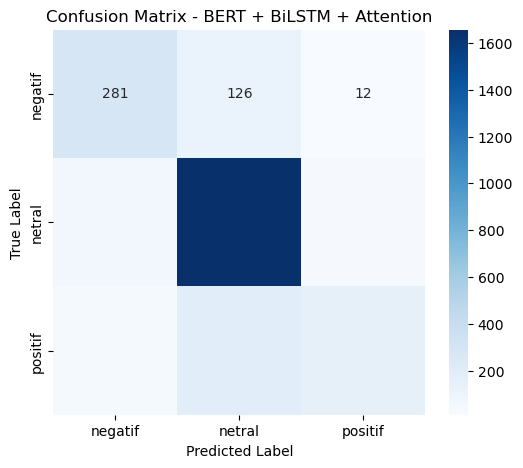

Classification Report:
              precision    recall  f1-score   support

     negatif       0.73      0.67      0.70       419
      netral       0.84      0.95      0.89      1749
     positif       0.78      0.39      0.52       396

    accuracy                           0.82      2564
   macro avg       0.78      0.67      0.70      2564
weighted avg       0.81      0.82      0.80      2564



In [14]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - BERT + BiLSTM + Attention')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))